## Model Evaluation

model evaluation against RAVDESS, CREMA-D, SAVEE, TESS and EMO-DB

In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.models import load_model

In [2]:
# Constants
EMOTION_COL = "Emotions"
PATH_COL = "Path"

NEUTRAL = "neutral"
CALM = "calm"
HAPPY = "happy"
SAD = "sad"
ANGRY = "angry"
FEAR = "fear"
DISGUST = "disgust"
SURPRISE = "surprise"
BOREDOM = "boredom"

EMOTIONS = [NEUTRAL, HAPPY, SAD, ANGRY, FEAR, DISGUST]


ZCR = "ZCR"
CHROMA_STFT = "CHROMA_STFT"
MFCC = "MFCC"
RMS = "RMS"
MEL_SPECTROGRAM = "MEL_SPECTROGRAM"
TEAGER_ENERGY_MFCC = "TEAGER_ENERGY_MFCC"

In [3]:
# datasets paths

Ravdess = "/Users/shenalfernando/Documents/FYP/Implementation/ravdess-dataset/"
Crema = "/Users/shenalfernando/Documents/FYP/Implementation/CREMA-D/"
Tess = "/Users/shenalfernando/Documents/FYP/Implementation/TESS/"
Savee = "/Users/shenalfernando/Documents/FYP/Implementation/SAVEE/"
EmoDB = "/Users/shenalfernando/Documents/FYP/Implementation/EmoDB/"

In [4]:
# helper function for EmoDB
def assemble_emo_db(dataset_path):
    berlin_dataset = os.listdir(dataset_path)
    emotions = []
    paths = []
    
    for file in berlin_dataset:
        paths.append(dataset_path + file)
        parts = file.split('.')[0]
        element = parts[5]
        if element == 'W':
            emotions.append(ANGRY)
        elif element == 'E':
            emotions.append(DISGUST)
        elif element == 'A':
            emotions.append(FEAR)
        elif element == 'F':
            emotions.append(HAPPY)
        elif element == 'N':
            emotions.append(NEUTRAL)
        elif element == 'T':
            emotions.append(SAD)
        else:
            emotions.append(BOREDOM)
            
    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])
    
    emo_df = pd.concat([emotions_df, paths_df], axis=1)
    return emo_df

In [5]:
# function to re-assemble the emotion with file_path in RAVDESS dataset
def assemble_ravdess_dataset(dataset_path):
    ravdess_dataset = os.listdir(dataset_path)
    emotions = []
    paths = []

    for directory in ravdess_dataset:
        actor_folder = os.listdir(dataset_path + directory)
        for file in actor_folder:
            file_name = file.split(".")[0]
            parts = file_name.split("-")
            emotions.append(int(parts[2]))  # get the emotion category according to the number present file name
            paths.append(dataset_path + directory + "/" + file)

    # data frame for emotions
    emotion_df = pd.DataFrame(emotions, columns=[EMOTION_COL])

    # data frame for paths
    path_df = pd.DataFrame(paths, columns=[PATH_COL])

    ravdess_df = pd.concat([emotion_df, path_df], axis=1)
    ravdess_df.Emotions.replace({
        1: NEUTRAL,
        2: CALM,
        3: HAPPY,
        4: SAD,
        5: ANGRY,
        6: FEAR,
        7: DISGUST,
        8: SURPRISE
    }, inplace=True)

    return ravdess_df

In [6]:
# function to re-assemble the emotion with file_path in CREMA-D dataset
def assemble_crema_dataset(dataset_path):
    crema_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for file in crema_dataset:
        paths.append(dataset_path + file)
        parts = file.split('_')
        if parts[2] == 'SAD':
            emotions.append(SAD)
        elif parts[2] == 'ANG':
            emotions.append(ANGRY)
        elif parts[2] == 'DIS':
            emotions.append(DISGUST)
        elif parts[2] == 'FEA':
            emotions.append(FEAR)
        elif parts[2] == 'HAP':
            emotions.append(HAPPY)
        elif parts[2] == 'NEU':
            emotions.append(NEUTRAL)
        else:
            emotions.append('Unknown')

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    crema_df = pd.concat([emotions_df, paths_df], axis=1)
    return crema_df

In [7]:
# function to re-assemble the emotion with file_path in TESS dataset
def assemble_tess_dataset(dataset_path):
    tess_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for directory in tess_dataset:
        directories = os.listdir(dataset_path + directory)
        for file in directories:
            file_name = file.split('.')[0]
            emotion = file_name.split('_')[2]
            if emotion == 'ps':
                emotions.append(SURPRISE)
            else:
                emotions.append(emotion)
            paths.append(dataset_path + directory + "/" + file)

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    tess_df = pd.concat([emotions_df, paths_df], axis=1)
    return tess_df

In [8]:
# function to re-assemble the emotion with file_path in SAVEE dataset
def assemble_savee_dataset(dataset_path):
    savee_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for file in savee_dataset:
        paths.append(dataset_path + file)
        parts = file.split('_')[1]
        emotion = parts[:-6]
        if emotion == 'a':
            emotions.append('angry')
        elif emotion == 'd':
            emotions.append('disgust')
        elif emotion == 'f':
            emotions.append('fear')
        elif emotion == 'h':
            emotions.append('happy')
        elif emotion == 'n':
            emotions.append('neutral')
        elif emotion == 'sa':
            emotions.append('sad')
        else:
            emotions.append('surprise')

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    savee_df = pd.concat([emotions_df, paths_df], axis=1)
    return savee_df

In [9]:
# to visualize the dataframe
def visualize_dataset(dataset_path, title, x_label, y_label):
    plt.title(title, size=16)
    sns.countplot(dataset_path, x='Emotions')
    plt.xlabel(x_label, size=12)
    plt.ylabel(y_label, size=12)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.show()
    

In [10]:
# some helper functions for feature extractions combination
# extract MFCC
def extract_mfcc(data, sample_rate):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

# extract mel spectrogram
def extract_mel_spectrogram(data, sample_rate):
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    return mel_spectrogram


def extract_features(signal, sample_rate):
    result = np.array([])
    
    mfcc_features = extract_mfcc(signal, sample_rate)
    result = np.hstack((result, mfcc_features))
    
    mel_spectrogram = extract_mel_spectrogram(signal, sample_rate)
    result = np.hstack((result, mel_spectrogram))
    
    return result

def combine_features(path):
    signal, sample_rate = librosa.load(path)
    pure_result = extract_features(signal, sample_rate)
    
    result = np.array(pure_result)
    return result

In [11]:
# some helper functions for evaluation support
# visualize the confusion matrix report
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidths=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

In [12]:
def filter_df(df):
    filtered_df = df[df[EMOTION_COL].isin(EMOTIONS)]
    return filtered_df

In [13]:
def get_combined_features(df):
    x, y = [], []
    for path, emotion in zip(df.Path, df.Emotions):
        features = combine_features(path)
        x.append(features)
        y.append(emotion)
    return x, y

In [22]:
def visualize_model_evaluation(x,y,dataset):
    # loading the saved model
    model_path = 'ser-model.h5'
    cnn_model = load_model(model_path)
    
    # feature arrangement
    features = pd.DataFrame(x)
    features['labels'] = y
    features.to_csv('{}_evaluation_features.csv'.format(dataset), index=False)
    features.head()
    
    labels = features['labels']
    label_mapping = {
    'angry': 0,
    'fear': 1,
    'disgust': 2,
    'sad': 3,
    'happy': 4,
    'neutral': 5
    }
    
    numerical_labels = labels.map(label_mapping)
    
    features['labels'] = numerical_labels
    
    x = features.iloc[: ,:-1].values
    y = features['labels'].values
    
    
    # improving data compatability to model
    # scaling our data with sklearn's Standard scaler
    scaler = StandardScaler()
    x_test = scaler.fit_transform(x)
    
    x_test = np.expand_dims(x_test, axis=2)
    y_test = y
    
    # predictions against db
    pred_test = cnn_model.predict(x_test)
    y_pred = [np.argmax(i) for i in pred_test]
    df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
    df['Predicted Labels'] = y_pred
    df['Actual Labels'] = y_test
    print(df.head())
    
    display_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

In [15]:
# ravdess dataset
ravdess_df = assemble_ravdess_dataset(Ravdess)
ravdess_df.head()

,Emotions,Path
0,angry,/Users/shenalfernando/Documents/FYP/Implementa...
1,fear,/Users/shenalfernando/Documents/FYP/Implementa...
2,fear,/Users/shenalfernando/Documents/FYP/Implementa...
3,angry,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


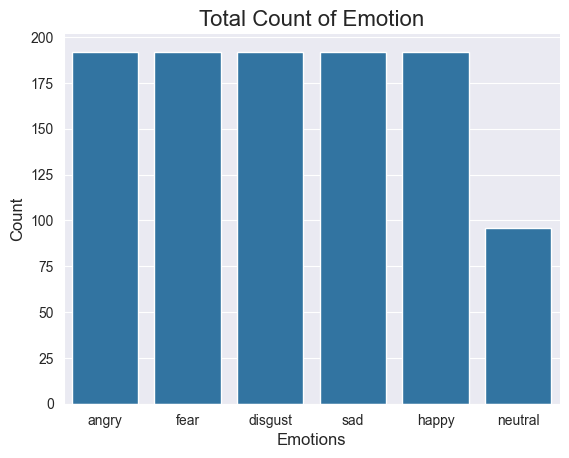

In [16]:
ravdess_filtered = filter_df(ravdess_df)
ravdess_filtered.head()
visualize_dataset(ravdess_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [17]:
ravdess_features_x, ravdess_features_y = get_combined_features(ravdess_filtered)

In [18]:
len(ravdess_features_x), len(ravdess_features_y), ravdess_filtered.Path.shape

(1056, 1056, (1056,))

33/33 [==============================] - 0s 6ms/step
   Predicted Labels  Actual Labels
0                 1              0
1                 1              1
2                 1              1
3                 0              0
4                 1              2


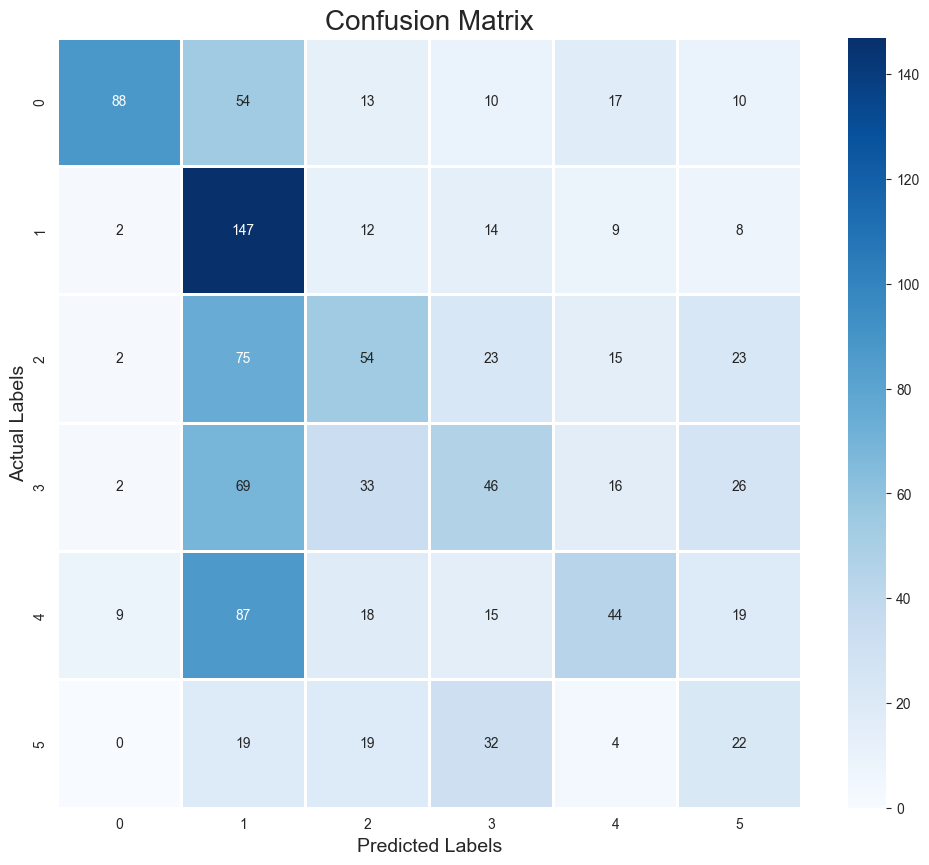

              precision    recall  f1-score   support

           0       0.85      0.46      0.60       192
           1       0.33      0.77      0.46       192
           2       0.36      0.28      0.32       192
           3       0.33      0.24      0.28       192
           4       0.42      0.23      0.30       192
           5       0.20      0.23      0.22        96

    accuracy                           0.38      1056
   macro avg       0.42      0.37      0.36      1056
weighted avg       0.43      0.38      0.37      1056


In [23]:
visualize_model_evaluation(ravdess_features_x, ravdess_features_y, "ravdess")

In [24]:
# crema-d dataset
crema_df = assemble_crema_dataset(Crema)
crema_df.head()

,Emotions,Path
0,angry,/Users/shenalfernando/Documents/FYP/Implementa...
1,angry,/Users/shenalfernando/Documents/FYP/Implementa...
2,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
3,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


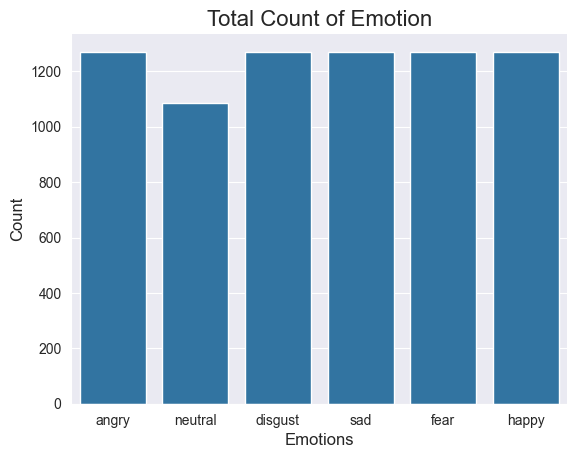

In [25]:
crema_filtered = filter_df(crema_df)
crema_filtered.head()
visualize_dataset(crema_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [26]:
crema_features_x, crema_features_y = get_combined_features(crema_filtered)

In [27]:
len(crema_features_x), len(crema_features_y), crema_filtered.Path.shape

(7442, 7442, (7442,))

233/233 [==============================] - 1s 6ms/step
   Predicted Labels  Actual Labels
0                 0              0
1                 1              0
2                 2              5
3                 2              5
4                 5              2


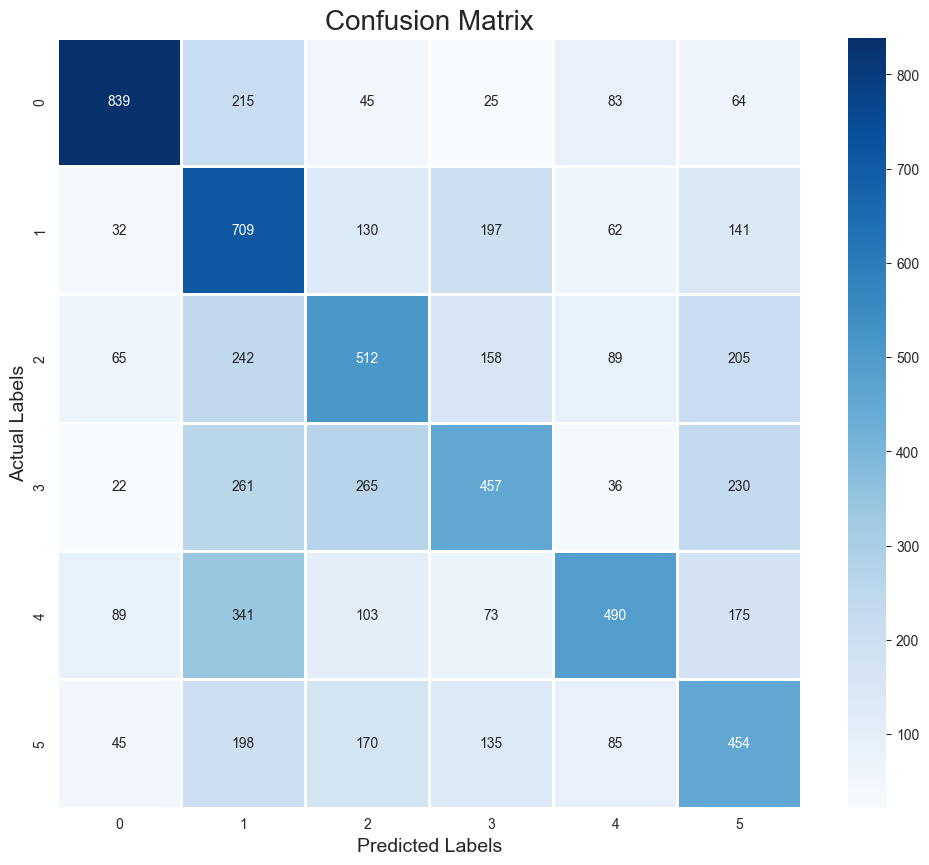

              precision    recall  f1-score   support

           0       0.77      0.66      0.71      1271
           1       0.36      0.56      0.44      1271
           2       0.42      0.40      0.41      1271
           3       0.44      0.36      0.39      1271
           4       0.58      0.39      0.46      1271
           5       0.36      0.42      0.39      1087

    accuracy                           0.47      7442
   macro avg       0.49      0.46      0.47      7442
weighted avg       0.49      0.47      0.47      7442


In [28]:
visualize_model_evaluation(crema_features_x,crema_features_y, "crema")

In [29]:
# tess dataset
tess_df = assemble_tess_dataset(Tess)
tess_df.head()

,Emotions,Path
0,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
1,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
2,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
3,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


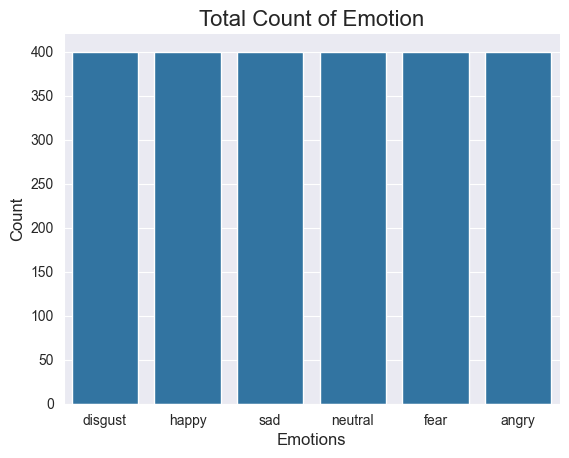

In [30]:
tess_filtered = filter_df(tess_df)
tess_filtered.head()
visualize_dataset(tess_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [31]:
tess_features_x, tess_features_y = get_combined_features(tess_filtered)

In [32]:
len(tess_features_x), len(tess_features_y), tess_filtered.Path.shape

(2400, 2400, (2400,))

75/75 [==============================] - 0s 6ms/step
   Predicted Labels  Actual Labels
0                 2              2
1                 5              2
2                 2              2
3                 2              2
4                 4              2


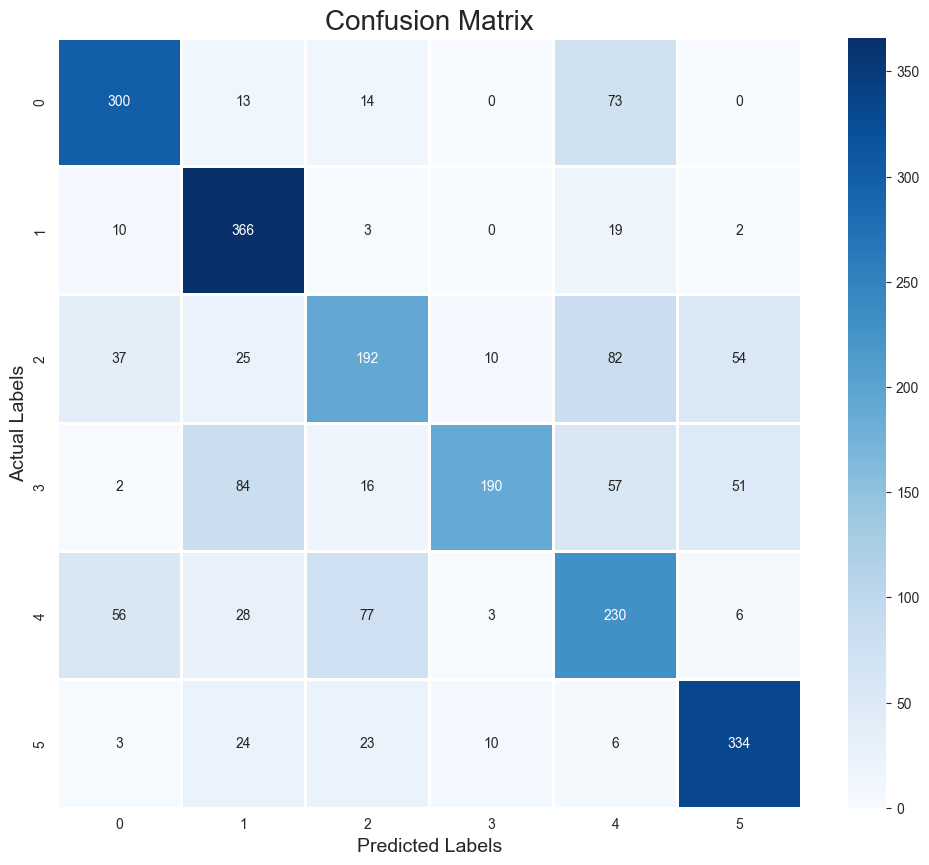

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       400
           1       0.68      0.92      0.78       400
           2       0.59      0.48      0.53       400
           3       0.89      0.47      0.62       400
           4       0.49      0.57      0.53       400
           5       0.75      0.83      0.79       400

    accuracy                           0.67      2400
   macro avg       0.69      0.67      0.67      2400
weighted avg       0.69      0.67      0.67      2400


In [33]:
visualize_model_evaluation(tess_features_x, tess_features_y, "tess")

In [34]:
# savee dataset
savee_df = assemble_savee_dataset(Savee)
savee_df.head()


,Emotions,Path
0,sad,/Users/shenalfernando/Documents/FYP/Implementa...
1,sad,/Users/shenalfernando/Documents/FYP/Implementa...
2,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
3,surprise,/Users/shenalfernando/Documents/FYP/Implementa...
4,neutral,/Users/shenalfernando/Documents/FYP/Implementa...


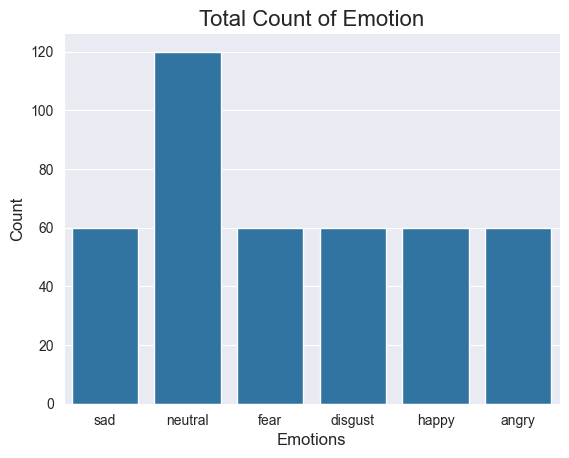

In [35]:
savee_filtered = filter_df(savee_df)
savee_filtered.head()
visualize_dataset(savee_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [36]:
savee_features_x, savee_features_y = get_combined_features(savee_filtered)

In [37]:
len(savee_features_x), len(savee_features_y), savee_filtered.Path.shape

(420, 420, (420,))

14/14 [==============================] - 0s 6ms/step
   Predicted Labels  Actual Labels
0                 2              3
1                 3              3
2                 1              5
3                 2              5
4                 2              5


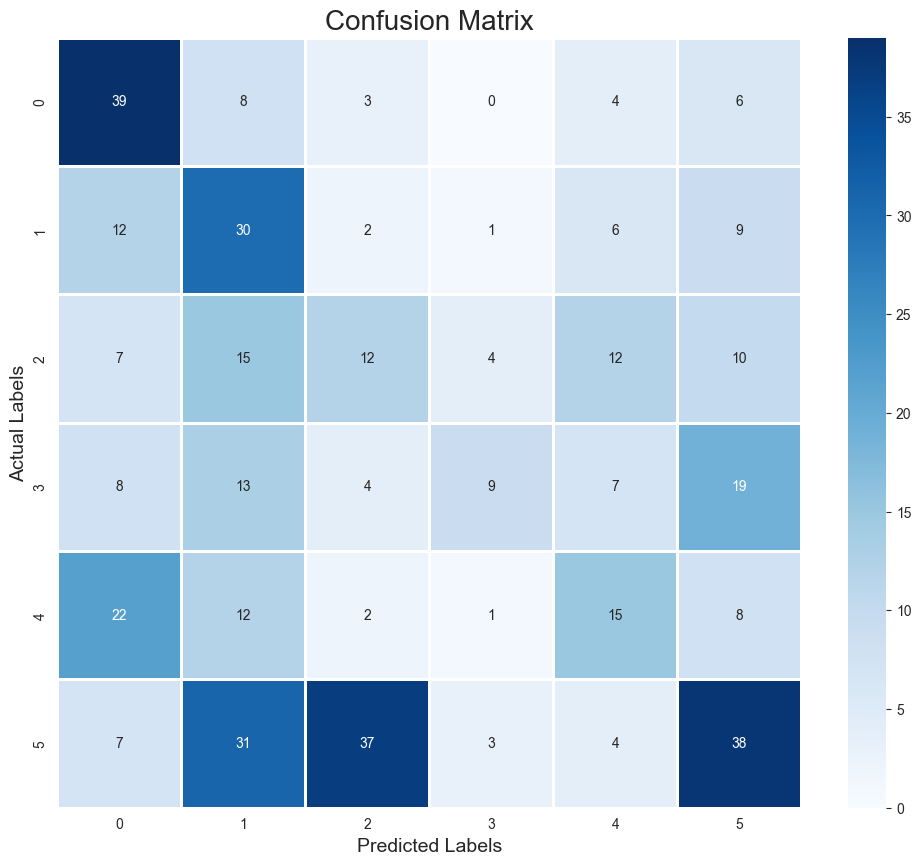

              precision    recall  f1-score   support

           0       0.41      0.65      0.50        60
           1       0.28      0.50      0.36        60
           2       0.20      0.20      0.20        60
           3       0.50      0.15      0.23        60
           4       0.31      0.25      0.28        60
           5       0.42      0.32      0.36       120

    accuracy                           0.34       420
   macro avg       0.35      0.34      0.32       420
weighted avg       0.36      0.34      0.33       420


In [38]:
visualize_model_evaluation(savee_features_x, savee_features_y, "savee")

In [39]:
# emo db
emo_db_df = assemble_emo_db(EmoDB)
emo_db_df.head()

,Emotions,Path
0,boredom,/Users/shenalfernando/Documents/FYP/Implementa...
1,angry,/Users/shenalfernando/Documents/FYP/Implementa...
2,fear,/Users/shenalfernando/Documents/FYP/Implementa...
3,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
4,angry,/Users/shenalfernando/Documents/FYP/Implementa...


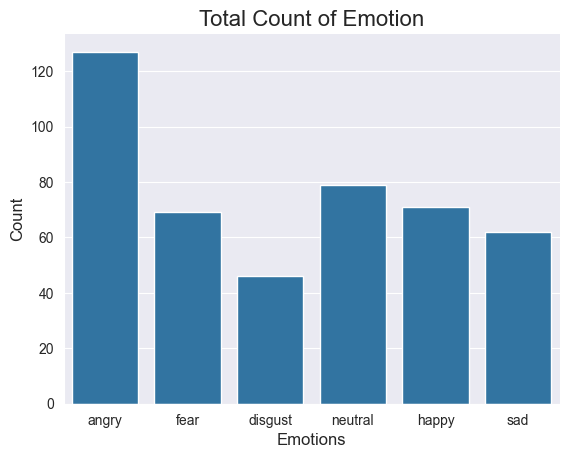

In [40]:
emo_db_filtered = filter_df(emo_db_df)
emo_db_filtered.head()
visualize_dataset(emo_db_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [41]:
emo_db_features_x, emo_db_features_y = get_combined_features(emo_db_filtered)

In [42]:
len(emo_db_features_x), len(emo_db_features_y), emo_db_filtered.Path.shape

(454, 454, (454,))

15/15 [==============================] - 0s 6ms/step
   Predicted Labels  Actual Labels
0                 0              0
1                 1              1
2                 1              2
3                 0              0
4                 1              5


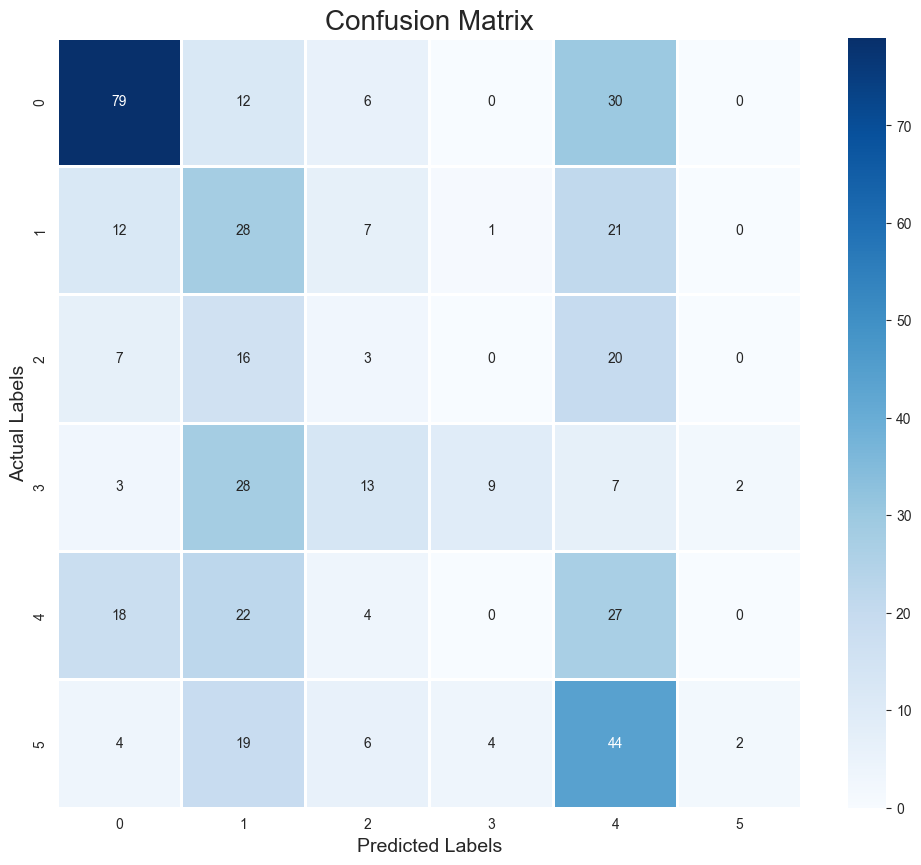

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       127
           1       0.22      0.41      0.29        69
           2       0.08      0.07      0.07        46
           3       0.64      0.15      0.24        62
           4       0.18      0.38      0.25        71
           5       0.50      0.03      0.05        79

    accuracy                           0.33       454
   macro avg       0.38      0.27      0.25       454
weighted avg       0.42      0.33      0.31       454


In [43]:
visualize_model_evaluation(emo_db_features_x, emo_db_features_y, "emo_db")